# Pulse Parametrization for Krotov's Method

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

This example illustrates the parametrization of control pulses as a
form of amplitude constraint.

In [1]:
datadir(names...) = joinpath(@__DIR__, names...);

In [2]:
using QuantumControl
using QuantumControl.Shapes: flattop
using QuantumControl.Generators
using QuantumControl.Controls
using QuantumControl.PulseParametrizations:
    SquareParametrization,
    TanhParametrization,
    TanhSqParametrization,
    LogisticParametrization,
    LogisticSqParametrization,
    ParametrizedAmplitude
using QuantumPropagators: ExpProp
using LinearAlgebra

In [3]:
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :top,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8),
)

## Parametrizations

## Symmetric Bounded Controls

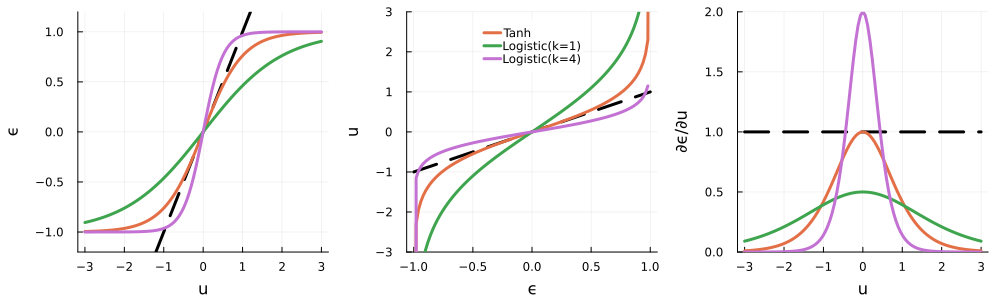

In [4]:
include(joinpath(@__DIR__, "plots", "symmetric_parametrization_comparison.jl"))  #hide
fig = plot_symmetric_parametrization_comparison()  #hide

## Positive (Bounded) Controls

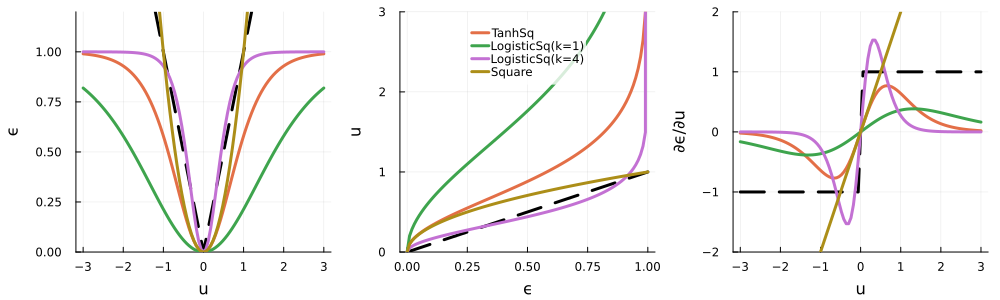

In [5]:
include(joinpath(@__DIR__, "plots", "positive_parametrization_comparison.jl"))  #hide
fig = plot_positive_parametrization_comparison()  #hide

## Two-level Hamiltonian

We consider the Hamiltonian $\op{H}_{0} = - \frac{\omega}{2} \op{\sigma}_{z}$, representing
a simple qubit with energy level splitting $\omega$ in the basis
$\{\ket{0},\ket{1}\}$. The control field $\epsilon(t)$ is assumed to couple via
the Hamiltonian $\op{H}_{1}(t) = \epsilon(t) \op{\sigma}_{x}$ to the qubit,
i.e., the control field effectively drives transitions between both qubit
states.

We we will use

In [6]:
ϵ(t) = 0.2 * flattop(t, T=5, t_rise=0.3, func=:blackman);

In [7]:
"""Two-level-system Hamiltonian."""
function tls_hamiltonian(; Ω=1.0, ampl=ϵ)
    σ̂_z = ComplexF64[
        1  0
        0 -1
    ]
    σ̂_x = ComplexF64[
        0  1
        1  0
    ]
    Ĥ₀ = -0.5 * Ω * σ̂_z
    Ĥ₁ = σ̂_x
    return hamiltonian(Ĥ₀, (Ĥ₁, ampl))
end;

In [8]:
H = tls_hamiltonian();

The control field here switches on from zero at $t=0$ to it's maximum amplitude
0.2 within the time period 0.3 (the switch-on shape is half a [Blackman pulse](https://en.wikipedia.org/wiki/Window_function#Blackman_window)).
It switches off again in the time period 0.3 before the
final time $T=5$). We use a time grid with 500 time steps between 0 and $T$:

In [9]:
tlist = collect(range(0, 5, length=500));
nothing #hide

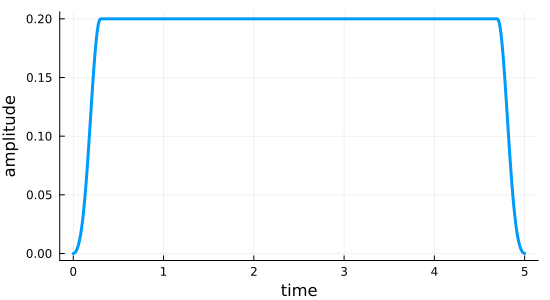

In [10]:
function plot_amplitude(ampl, tlist)
    plot(tlist, discretize(ampl, tlist), xlabel="time", ylabel="amplitude", legend=false)
end

fig = plot_amplitude(ϵ, tlist)

## Optimization target

The `Krotov` package requires the optimization to be expressed over a set of
"trajectories". In this example, there is only a single
trajectory: the state-to-state transfer from initial state $\ket{\Psi_{\init}} =
\ket{0}$ to the target state $\ket{\Psi_{\tgt}} = \ket{1}$, under the dynamics
of the Hamiltonian $\op{H}(t)$:

In [11]:
function ket(label)
    result = Dict("0" => Vector{ComplexF64}([1, 0]), "1" => Vector{ComplexF64}([0, 1]),)
    return result[string(label)]
end;

In [12]:
trajectories = [Trajectory(ket(0), H, target_state=ket(1))]

1-element Vector{QuantumControlBase.Trajectory{Vector{ComplexF64}, QuantumPropagators.Generators.Generator{Matrix{ComplexF64}, typeof(Main.var"##225".ϵ)}}}:
 Trajectory with 2-element Vector{ComplexF64} initial state, Generator with 2 ops and 1 amplitudes, 2-element Vector{ComplexF64} target state

## Square-parametrization for positive pulses

In [13]:
a = ParametrizedAmplitude(
    ϵ,
    tlist;
    parametrization=SquareParametrization(),
    parameterize=true
)

ParametrizedAmplitude(::Vector{Float64}; parametrization=SquareParametrization())

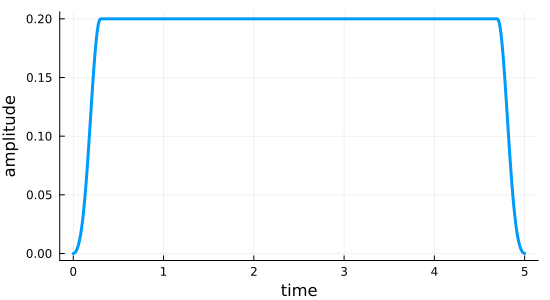

In [14]:
function plot_amplitude(ampl::ParametrizedAmplitude, tlist)
    plot(
        tlist,
        discretize(Array(ampl), tlist),
        xlabel="time",
        ylabel="amplitude",
        legend=false
    )
end

fig = plot_amplitude(a, tlist)

In [15]:
problem = ControlProblem(
    trajectories=substitute(trajectories, IdDict(ϵ => a)),
    prop_method=ExpProp,
    lambda_a=5,
    update_shape=(t -> flattop(t, T=5, t_rise=0.3, func=:blackman)),
    tlist=tlist,
    iter_stop=50,
    J_T=QuantumControl.Functionals.J_T_ss,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end
);

In [16]:
using Krotov
opt_result_positive = @optimize_or_load(
    datadir("parametrization#opt_result_positive.jld2"),
    problem;
    method=Krotov
);

 iter.        J_T   ∫gₐ(t)dt          J       ΔJ_T         ΔJ    secs
     0   9.51e-01   0.00e+00   9.51e-01        n/a        n/a     3.5
[ Info: Set callback to store result in parametrization#opt_result_positive.jld2 on unexpected exit.
     1   9.31e-01   9.29e-03   9.40e-01  -2.05e-02  -1.12e-02     1.6
     2   9.01e-01   1.34e-02   9.15e-01  -2.96e-02  -1.63e-02     0.0
     3   8.59e-01   1.91e-02   8.78e-01  -4.25e-02  -2.34e-02     0.1
     4   7.99e-01   2.67e-02   8.26e-01  -5.96e-02  -3.29e-02     0.0
     5   7.20e-01   3.56e-02   7.56e-01  -7.91e-02  -4.35e-02     0.0
     6   6.25e-01   4.33e-02   6.68e-01  -9.52e-02  -5.19e-02     0.0
     7   5.25e-01   4.62e-02   5.72e-01  -9.96e-02  -5.33e-02     0.0
     8   4.36e-01   4.25e-02   4.79e-01  -8.92e-02  -4.66e-02     0.0
     9   3.65e-01   3.49e-02   4.00e-01  -7.14e-02  -3.64e-02     0.0
    10   3.10e-01   2.74e-02   3.37e-01  -5.48e-02  -2.74e-02     0.0
    11   2.68e-01   2.14e-02   2.89e-01  -4.24e-02  -2.09e-

In [17]:
opt_result_positive

Krotov Optimization Result
--------------------------
- Started at 2024-05-23T12:07:34.649
- Number of trajectories: 1
- Number of iterations: 50
- Value of functional: 3.53585e-02
- Reason for termination: Reached maximum number of iterations
- Ended at 2024-05-23T12:07:40.377 (5 seconds, 728 milliseconds)


We can plot the optimized field:

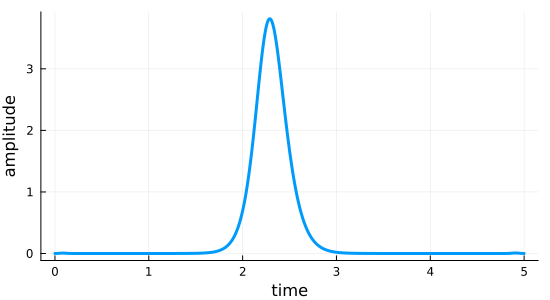

In [18]:
fig = plot_amplitude(
    substitute(a, IdDict(a.control => opt_result_positive.optimized_controls[1])),
    tlist
)

## Tanh-Square-Parametrization for positive amplitude-constrained pulses

In [19]:
a = ParametrizedAmplitude(
    ϵ,
    tlist;
    parametrization=TanhSqParametrization(3),
    parameterize=true
)

problem_tanhsq = ControlProblem(
    trajectories=substitute(trajectories, IdDict(ϵ => a)),
    prop_method=ExpProp,
    lambda_a=10,
    update_shape=(t -> flattop(t, T=5, t_rise=0.3, func=:blackman)),
    tlist=tlist,
    iter_stop=50,
    J_T=QuantumControl.Functionals.J_T_ss,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end
);

In [20]:
opt_result_tanhsq = @optimize_or_load(
    datadir("parametrization#opt_result_tanhsq.jld2"),
    problem_tanhsq;
    method=Krotov
);

 iter.        J_T   ∫gₐ(t)dt          J       ΔJ_T         ΔJ    secs
     0   9.51e-01   0.00e+00   9.51e-01        n/a        n/a     0.1
[ Info: Set callback to store result in parametrization#opt_result_tanhsq.jld2 on unexpected exit.
     1   9.24e-01   1.21e-02   9.36e-01  -2.76e-02  -1.54e-02     0.0
     2   8.81e-01   1.90e-02   9.00e-01  -4.32e-02  -2.42e-02     0.0
     3   8.15e-01   2.88e-02   8.44e-01  -6.54e-02  -3.65e-02     0.0
     4   7.24e-01   4.06e-02   7.65e-01  -9.08e-02  -5.02e-02     0.0
     5   6.16e-01   4.99e-02   6.65e-01  -1.09e-01  -5.90e-02     0.0
     6   5.08e-01   5.11e-02   5.59e-01  -1.08e-01  -5.66e-02     0.0
     7   4.19e-01   4.38e-02   4.62e-01  -8.92e-02  -4.54e-02     0.0
     8   3.52e-01   3.37e-02   3.85e-01  -6.69e-02  -3.33e-02     0.0
     9   3.02e-01   2.51e-02   3.28e-01  -4.92e-02  -2.41e-02     0.0
    10   2.66e-01   1.89e-02   2.84e-01  -3.69e-02  -1.79e-02     0.0
    11   2.37e-01   1.46e-02   2.52e-01  -2.84e-02  -1.38e-02

In [21]:
opt_result_tanhsq

Krotov Optimization Result
--------------------------
- Started at 2024-05-23T12:07:43.054
- Number of trajectories: 1
- Number of iterations: 50
- Value of functional: 6.69321e-02
- Reason for termination: Reached maximum number of iterations
- Ended at 2024-05-23T12:07:43.613 (559 milliseconds)


We can plot the optimized field:

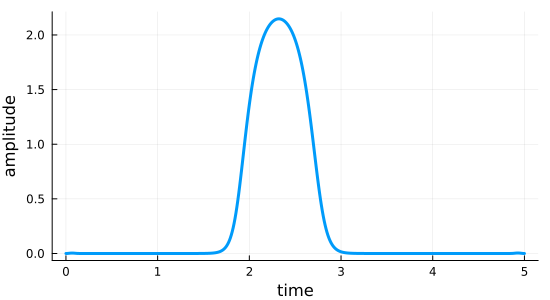

In [22]:
fig = plot_amplitude(
    substitute(a, IdDict(a.control => opt_result_tanhsq.optimized_controls[1])),
    tlist
)

## Logistic-Square-Parametrization for positive amplitude-constrained pulses

In [23]:
a = ParametrizedAmplitude(
    ϵ,
    tlist;
    parametrization=LogisticSqParametrization(3, k=1.0),
    parameterize=true
)

problem_logisticsq = ControlProblem(
    trajectories=substitute(trajectories, IdDict(ϵ => a)),
    prop_method=ExpProp,
    lambda_a=1,
    update_shape=(t -> flattop(t, T=5, t_rise=0.3, func=:blackman)),
    tlist=tlist,
    iter_stop=50,
    J_T=QuantumControl.Functionals.J_T_ss,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end
);

In [24]:
opt_result_logisticsq = @optimize_or_load(
    datadir("parametrization#opt_result_logisticsq.jld2"),
    problem_logisticsq;
    method=Krotov
);

 iter.        J_T   ∫gₐ(t)dt          J       ΔJ_T         ΔJ    secs
     0   9.51e-01   0.00e+00   9.51e-01        n/a        n/a     0.1
[ Info: Set callback to store result in parametrization#opt_result_logisticsq.jld2 on unexpected exit.
     1   8.72e-01   2.97e-02   9.02e-01  -7.91e-02  -4.93e-02     0.0
     2   6.93e-01   6.94e-02   7.63e-01  -1.79e-01  -1.10e-01     0.0
     3   4.57e-01   1.03e-01   5.60e-01  -2.36e-01  -1.33e-01     0.0
     4   3.07e-01   7.51e-02   3.82e-01  -1.50e-01  -7.49e-02     0.0
     5   2.31e-01   4.00e-02   2.71e-01  -7.60e-02  -3.60e-02     0.0
     6   1.87e-01   2.31e-02   2.10e-01  -4.37e-02  -2.06e-02     0.0
     7   1.59e-01   1.48e-02   1.74e-01  -2.82e-02  -1.34e-02     0.0
     8   1.39e-01   1.03e-02   1.49e-01  -1.97e-02  -9.38e-03     0.0
     9   1.25e-01   7.53e-03   1.32e-01  -1.45e-02  -6.93e-03     0.0
    10   1.14e-01   5.74e-03   1.19e-01  -1.11e-02  -5.33e-03     0.0
    11   1.05e-01   4.52e-03   1.09e-01  -8.75e-03  -4.23

We can plot the optimized field:

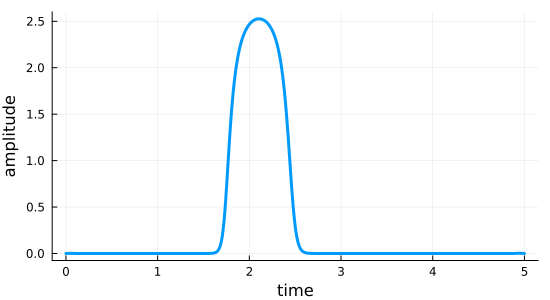

In [25]:
fig = plot_amplitude(
    substitute(a, IdDict(a.control => opt_result_logisticsq.optimized_controls[1])),
    tlist
)

## Tanh-parametrization for amplitude-constrained pulses

In [26]:
a = ParametrizedAmplitude(
    ϵ,
    tlist;
    parametrization=TanhParametrization(-0.5, 0.5),
    parameterize=true
)

problem_tanh = ControlProblem(
    trajectories=substitute(trajectories, IdDict(ϵ => a)),
    prop_method=ExpProp,
    lambda_a=1,
    update_shape=(t -> flattop(t, T=5, t_rise=0.3, func=:blackman)),
    tlist=tlist,
    iter_stop=50,
    J_T=QuantumControl.Functionals.J_T_ss,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end
);

In [27]:
opt_result_tanh = @optimize_or_load(
    datadir("parametrization#opt_result_tanh.jld2"),
    problem_tanh;
    method=Krotov
);

 iter.        J_T   ∫gₐ(t)dt          J       ΔJ_T         ΔJ    secs
     0   9.51e-01   0.00e+00   9.51e-01        n/a        n/a     0.1
[ Info: Set callback to store result in parametrization#opt_result_tanh.jld2 on unexpected exit.
     1   9.27e-01   1.09e-02   9.38e-01  -2.40e-02  -1.31e-02     0.0
     2   8.93e-01   1.56e-02   9.09e-01  -3.42e-02  -1.87e-02     0.0
     3   8.46e-01   2.18e-02   8.67e-01  -4.77e-02  -2.59e-02     0.0
     4   7.82e-01   2.94e-02   8.11e-01  -6.37e-02  -3.43e-02     0.0
     5   7.03e-01   3.70e-02   7.40e-01  -7.89e-02  -4.18e-02     0.0
     6   6.16e-01   4.18e-02   6.58e-01  -8.68e-02  -4.50e-02     0.0
     7   5.33e-01   4.12e-02   5.74e-01  -8.33e-02  -4.21e-02     0.0
     8   4.62e-01   3.59e-02   4.98e-01  -7.11e-02  -3.52e-02     0.0
     9   4.05e-01   2.89e-02   4.34e-01  -5.66e-02  -2.77e-02     0.0
    10   3.61e-01   2.26e-02   3.84e-01  -4.40e-02  -2.14e-02     0.0
    11   3.27e-01   1.76e-02   3.44e-01  -3.43e-02  -1.67e-02  

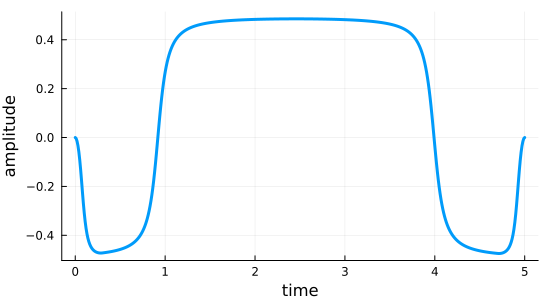

In [28]:
fig = plot_amplitude(
    substitute(a, IdDict(a.control => opt_result_tanh.optimized_controls[1])),
    tlist
)